![NO SE PUEDE MOSTRAR](Imagenes/baner2.jpg)

# Función para instalar/actualizar paquetes

In [1]:
# Ejecutar el comando para instalar/actualizar paquetes
!pip install -r requirements.txt

# Importación Librerías

In [2]:
import pandas as pd
from io import StringIO
import gdown
import json
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ast
from collections import Counter
import numpy as np
import re
import time
from sqlalchemy import create_engine, Column, String, Integer, Table, MetaData, text
import mysql.connector


# Extracción

## Carga de Archivos Inmobiliaria

Presentamos estos datos de una inmobiliaria cuyo caso de implementación del sistema FindEden fué un éxito.

In [3]:
%run Archivos_Inmobiliaria/script_sql_genera_csv.py

Archivo Propiedades.csv guardado en ../datasets/SQL/.
Archivo Publicaciones_Alquileres.csv guardado en ../datasets/SQL/.
Archivo Inquilinos.csv guardado en ../datasets/SQL/.
Archivo Contratos.csv guardado en ../datasets/SQL/.
Todos los archivos CSV han sido guardados en la carpeta local.


C:\Users\londe\OneDrive\Programacion\1 - Henrry\Data Science\CLASES - DATA\PROYECTO FINAL\PFH_Google_Yelp\Archivos_Inmobiliaria\script_sql_genera_csv.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


## Descarga de Archivos

### 1 - Metadata - Google

In [4]:
# IDs de los archivos de Google Drive
file_links = [
    'https://drive.google.com/file/d/1OnyhmyG8xzdn4XU9LYcnwzBseB1_rChS', 
    'https://drive.google.com/file/d/15D_5EkxqPP0XJb5I5bYI8b1wQV7B2fx_', 
    'https://drive.google.com/file/d/1fDBVCmf4JA7gkIyjpv5mHEMySb19C-vz', 
    'https://drive.google.com/file/d/1Mj2oUZy5gGznhthcUGi8_sgKhBwypE74', 
    'https://drive.google.com/file/d/1IXok40Zp61CGwFDgyvLUwV02c4BWGrjj',
    'https://drive.google.com/file/d/1UmsN_ZOFQqVl7W9SbnxHkSQavo1_Iwqx', 
    'https://drive.google.com/file/d/1KfQBhJlnuziKjf-9haQGaiPtCPnUUDla', 
    'https://drive.google.com/file/d/1ebTUx2klGy7L9lGlZl3GCPXxSwSD55vX', 
    'https://drive.google.com/file/d/1td6twU60LAS-z5mB0MeSJEpGhH7jcGKm', 
    'https://drive.google.com/file/d/1NQgHgNm9PV8MSiOXNoQ2UkIF9e5AdLk7', 
    'https://drive.google.com/file/d/1GYwWfH7EvWMZn14vQRNr5CjEely4eWrB'
]

# Nombres de los archivos locales (presumiendo que siguen el patrón 1.json, 2.json, ..., 11.json)
file_names = [f'{i}.json' for i in range(1, len(file_links) + 1)]

# Crear la carpeta MetadataGoogle si no existe
output_dir = 'datasets/MetadataGoogle'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Inicializar una lista para almacenar los DataFrames
dataframes = []

# Descargar y leer cada archivo JSON
for file_link, file_name in zip(file_links, file_names):
    try:
        # Ruta completa del archivo
        file_path = os.path.join(output_dir, file_name)
        
        # Verificar si el archivo ya está descargado
        if not os.path.exists(file_path):
            # Obtener el ID del archivo desde el enlace
            file_id = file_link.split('/d/')[1].split('/')[0]
            download_url = f'https://drive.google.com/uc?id={file_id}'
            
            # Descargar el archivo
            gdown.download(download_url, file_path, quiet=False)
        
        # Leer el archivo JSON en un DataFrame
        with open(file_path, 'r', encoding='utf-8') as file:
            first_char = file.read(1)
            if not first_char:
                raise ValueError(f"El archivo {file_name} está vacío.")
            file.seek(0)
            df = pd.read_json(file, lines=True)
        
        # Agregar el DataFrame a la lista
        dataframes.append(df)
    
    except Exception as e:
        print(f"Error al procesar el archivo {file_name}: {e}")
        if os.path.exists(file_path):
            os.remove(file_path)
            
df_metadatosCA = pd.concat(dataframes, ignore_index=True)

# Eliminar el DataFrame original para liberar memoria
del dataframes

#### a - Eliminar duplicados y Filtrar por Estado California

Este código combina varios DataFrames, filtra los datos por el estado de California y luego limpia el DataFrame resultante para que tenga un índice continuo y no tenga la columna de índice antigua.

In [5]:
# Eliminar duplicados basados en la columna 'gmap_id'
df_metadatosCA.drop_duplicates(subset=['gmap_id'], inplace=True)

In [6]:
# Filtrar por el estado de California (CA)
df_metadatosCA['estado'] = df_metadatosCA['address'].str.extract(r', ([A-Z]{2}) \d{5}')
df_metadatosCA = df_metadatosCA[df_metadatosCA['estado'] == 'CA']

# Resetear índice y eliminar la columna de índice antigua
df_metadatosCA.reset_index(inplace=True)
df_metadatosCA.drop('index', axis='columns', inplace=True)

#### b - Extraer Ciudad

Este código de Python está diseñado para extraer la ciudad de una columna de direcciones en un DataFrame de Pandas llamado df_metadatosCA.

Este código toma un DataFrame con direcciones y crea una nueva columna que contiene los nombres de las ciudades extraídas. Se basa en una expresión regular para identificar y extraer el nombre de la ciudad según un formato de dirección común.

In [7]:
# Función para extraer la ciudad y colocarla en una nueva columna
def extract_city(address):
    match = re.search(r',\s*([^,]+),\s*[A-Z]{2}\s*\d{5}', address)
    if match:
        return match.group(1).strip()
    return None

# Aplicar la función a la columna 'address' y crear la columna 'city'
df_metadatosCA['city'] = df_metadatosCA['address'].apply(extract_city)

#### c - Horas de Atención

Este script de Python está diseñado para analizar horarios de apertura y cierre de negocios y calcular las horas diurnas y nocturnas que están abiertos. 

Estas líneas usan la función apply para aplicar las funciones calculate_day_hours y calculate_night_hours a cada fila de la columna "hours" del DataFrame df_metadatosCA. El resultado de cada función se guarda en una nueva columna con el nombre correspondiente.



In [8]:
# Función para asegurarse de que el tiempo esté en el formato "HH:MMAM/PM"
def ensure_time_format(time_str):
    if '–' in time_str:
        parts = time_str.split('–')
        parts = [ensure_time_format(part) for part in parts]
        return '–'.join(parts)
    try:
        if ':' not in time_str:
            time_obj = pd.to_datetime(time_str, format='%I%p', errors='coerce')
        else:
            time_obj = pd.to_datetime(time_str, format='%I:%M%p', errors='coerce')
        if time_obj is not pd.NaT:
            return time_obj.strftime('%I:%M%p')
    except Exception as e:
        print(f"Error formatting time: {time_str}, error: {e}")
    return None

In [9]:
# Función para calcular las horas diurnas (8 AM - 10 PM)
def calculate_day_hours(hours_array):
    total_day_hours = 0
    if hours_array is not None and isinstance(hours_array, np.ndarray):
        for entry in hours_array:
            if isinstance(entry, np.ndarray) and len(entry) == 2:
                day, hours = entry
                if 'Closed' in hours:
                    continue
                if '–' in hours:
                    open_time, close_time = hours.split('–')
                    open_time = ensure_time_format(open_time)
                    close_time = ensure_time_format(close_time)
                    
                    if open_time and close_time:
                        open_hour = pd.to_datetime(open_time, format='%I:%M%p').hour
                        close_hour = pd.to_datetime(close_time, format='%I:%M%p').hour

                        if open_hour < 8:
                            open_hour = 8
                        if close_hour > 22:
                            close_hour = 22

                        if close_hour < open_hour:
                            close_hour += 24  # Para manejar el cambio de día

                        total_day_hours += max(0, close_hour - open_hour)
    return total_day_hours

In [10]:
# Función para calcular las horas nocturnas (10 PM - 8 AM)
def calculate_night_hours(hours_array):
    total_night_hours = 0
    if hours_array is not None and isinstance(hours_array, np.ndarray):
        for entry in hours_array:
            if isinstance(entry, np.ndarray) and len(entry) == 2:
                day, hours = entry
                if 'Closed' in hours:
                    continue
                if '–' in hours:
                    open_time, close_time = hours.split('–')
                    open_time = ensure_time_format(open_time)
                    close_time = ensure_time_format(close_time)

                    if open_time and close_time:
                        open_hour = pd.to_datetime(open_time, format='%I:%M%p').hour
                        close_hour = pd.to_datetime(close_time, format='%I:%M%p').hour

                        if close_hour < open_hour:
                            close_hour += 24  # Para manejar el cambio de día

                        night_hours = 0
                        if open_hour < 8:
                            night_hours += min(8, close_hour) - open_hour
                        if close_hour > 22:
                            night_hours += close_hour - 22

                        total_night_hours += max(0, night_hours)
    return total_night_hours

In [11]:
# Aplicar las funciones al DataFrame
df_metadatosCA['Hours_day'] = df_metadatosCA['hours'].apply(calculate_day_hours)
df_metadatosCA['Hours_night'] = df_metadatosCA['hours'].apply(calculate_night_hours)

#### d - Contabilizar Categorías

Este código de Python está diseñado para analizar las categorías de negocios en un DataFrame llamado df_metadatosCA y contar cuántas veces aparece cada categoría. 

In [12]:
# Expandir las listas en filas individuales
categorias_expandidas = df_metadatosCA['category'].explode()

# Contar las ocurrencias de cada categoría y convertir a DataFrame
conteo_categorias = categorias_expandidas.value_counts().reset_index()

# Renombrar las columnas para mayor claridad
conteo_categorias.columns = ['Categoria', 'Frecuencia']

# Mostrar el resultado
print(conteo_categorias)

                  Categoria  Frecuencia
0                Restaurant       11505
1          Auto repair shop        8729
2              Beauty salon        7846
3                Hair salon        5526
4                Nail salon        5419
...                     ...         ...
3849                  Asian           1
3850           Squash court           1
3851       Felt boots store           1
3852      Low emission zone           1
3853  Catalonian restaurant           1

[3854 rows x 2 columns]


In [13]:
num_categorias = len(conteo_categorias)
print(f"La Serie tiene {num_categorias} categorías únicas.")

La Serie tiene 3854 categorías únicas.


In [14]:
# Eliminar la serie que ya no se usa
del categorias_expandidas

#### e -Explotar la columna MISC

 Este código de Python está diseñado para tomar un DataFrame llamado df_metadatosCA que tiene una columna llamada 'MISC' que contiene diccionarios, y expandir esos diccionarios en nuevas columnas en el DataFrame.

In [15]:
# Función para extraer y expandir los diccionarios en nuevas columnas
def expand_misc_column(misc_dict):
    if pd.isna(misc_dict):
        return pd.Series()
    expanded = {}
    for key, value in misc_dict.items():
        if value is not None and isinstance(value, np.ndarray):
            expanded[key] = ', '.join(value)
        else:
            expanded[key] = value
    return pd.Series(expanded)

# Aplicar la función al DataFrame
expanded_df = df_metadatosCA['MISC'].apply(expand_misc_column)

# Unir el DataFrame original con el DataFrame expandido
df_metadatosCA = pd.concat([df_metadatosCA, expanded_df], axis=1)

#Eliminar la columna MISC que ya no se usa
df_metadatosCA.drop(columns='MISC', inplace=True)

del expanded_df

#### c - Machine Learning

El código filtra el conjunto de datos df_reviewsGoogle para obtener solo las reseñas que corresponden a los negocios que están en la lista "negocios". Luego, crea un nuevo conjunto de datos llamado df_reviewsGoogle_ML que contiene solo las columnas "user_id", "time", "rating" y "gmap_id" de las reseñas filtradas.

¿Para qué se utiliza este código?

Este código parece ser un paso inicial para preparar los datos para un modelo de Machine Learning. Al filtrar las reseñas de los negocios que te interesan, estás creando un conjunto de datos específico que puedes usar para entrenar un modelo que prediga algo relacionado con las reseñas, como la calificación promedio de un negocio o la probabilidad de que un usuario deje una reseña positiva.

In [16]:
# Elegir ciudad
ciudadelegida='Los Angeles'

In [17]:
#filtro el listado
negocios=df_metadatosCA['gmap_id'][df_metadatosCA['city'] == ciudadelegida]

In [18]:
#filtro por los negocios de la ciudad
# Generar el dataframe a exportar
metadatos_ML = df_metadatosCA.loc[df_metadatosCA['city'] == ciudadelegida, 
                           ['address', 'gmap_id', 'latitude', 'longitude',
                            'category', 'avg_rating', 'num_of_reviews', 'Hours_day', 'Hours_night']]

# Exportar el dataframe
metadatos_ML.to_csv('Archivos/metadatos_ML.csv', index=False)

### 2 - Reviews Estados - Google

In [19]:
# IDs de los archivos de Google Drive
file_links = [
    'https://drive.google.com/file/d/13JlGdagtTp4SrUIXu5osayX0f-vmeMz6',
    'https://drive.google.com/file/d/1PIruhKSA5gEwk93-jwKdlG_vtwJmBHWV', 
    'https://drive.google.com/file/d/1JVSi-345m8nt52m2_MPkLULZexbvZUAV', 
    'https://drive.google.com/file/d/1vYYCtcNcfdRzQpEskb8x-8npZUHj2XY-', 
    'https://drive.google.com/file/d/1nCyVnhNpfphd26ye3lj9UsWvPTEhik6b', 
    'https://drive.google.com/file/d/12PR9jUiZLYvjw6BZjwlexgsWmJlMOajN',
    'https://drive.google.com/file/d/1Oq1UdTmQ4xFgkaFdx09JXJQ1_pnIk-il', 
    'https://drive.google.com/file/d/1UwzEftWrssj8Vt0BAf_W9L_TVDGa9JD9', 
    'https://drive.google.com/file/d/1KsXni6or_cPKovgUaRI_3G4-mRXfqgog', 
    'https://drive.google.com/file/d/1fK2kTLDqlUcDt6bKa20W5LvOmrfemDrg', 
    'https://drive.google.com/file/d/1rMz_y1cqa8IBwv1K6K34fAXB2qoRjmEG', 
    'https://drive.google.com/file/d/1t59IfitryIsy8-F9NL9J6M75UElQO0i9',
    'https://drive.google.com/file/d/17VtmF8701j3Tk-tdHeRrXDzj32UyWFVh',
    'https://drive.google.com/file/d/1zoN6XJV220ofRKVlM8DP--FriL_OcZEP',
    'https://drive.google.com/file/d/1HUVCM9uOrXhoOzoSD9NqhHJ1PHrLEhBC',
    'https://drive.google.com/file/d/1sqp0YG4OHVUoA0gWrgwg1wXpdOlF5RfD',
    'https://drive.google.com/file/d/1SPDbJPTxKV1QqMcRNsHIhV7EZBLtRCWf',
    'https://drive.google.com/file/d/1_Ik1uLilfLe0MEb1Gia-t9SpE1Wwdwnm'
]

# Nombre de la carpeta que quieres crear
carpeta_destino = 'datasets/ReviewsEstadosGoogle'

# Verificar si la carpeta existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)
    print(f"Se ha creado la carpeta: {carpeta_destino}")
else:
    print(f"La carpeta {carpeta_destino} ya existe.")
    
# Nombres de los archivos locales (presumiendo que siguen el patrón 1.json, 2.json, ..., 11.json)
file_names = [f'datasets/ReviewsEstadosGoogle/{i}.json' for i in range(1, len(file_links) + 1)]

# Inicializar una lista para almacenar los DataFrames
dataframes = []

# Descargar y leer cada archivo JSON si no está descargado previamente
for file_link, file_name in zip(file_links, file_names):
    try:
        # Verificar si el archivo ya está descargado
        if not os.path.exists(file_name):
            # Obtener el ID del archivo desde el enlace
            file_id = file_link.split('/d/')[1].split('/')[0]
            download_url = f'https://drive.google.com/uc?id={file_id}'
            
            # Descargar el archivo
            gdown.download(download_url, file_name, quiet=False)
            
            # Verificar si el archivo descargado es un JSON válido
            with open(file_name, 'r', encoding='utf-8') as file:
                first_char = file.read(1)
                if not first_char:
                    raise ValueError(f"El archivo {file_name} está vacío.")
                file.seek(0)
            
        # Leer el archivo JSON en un DataFrame
        df = pd.read_json(file_name, lines=True)
        
        # Agregar el DataFrame a la lista
        dataframes.append(df)
    
    except Exception as e:
        print(f"Error al procesar el archivo {file_name}: {e}")

del df

# Concatenar todos los DataFrames en uno solo
df_reviewsGoogle = pd.concat(dataframes, ignore_index=True)

La carpeta datasets/ReviewsEstadosGoogle ya existe.


#### a - Eliminación de duplicados

 Este código elimina las filas duplicadas del DataFrame df_reviewsGoogle solo si las filas tienen los mismos valores en las columnas 'user_id', 'time' y 'gmap_id'. Esto es útil para asegurar que cada combinación única de estas tres columnas represente una reseña única.

In [20]:
df_reviewsGoogle.drop_duplicates(subset=['user_id', 'time', 'gmap_id'], inplace=True)

#### b - Tratamiento de Variables

Este código crea una nueva columna 'has_text' en el DataFrame df_reviewsGoogle. Esta columna tendrá un valor de 1 si la columna 'text' contiene texto real (no está vacía o solo espacios en blanco) y 0 si no contiene texto real.

In [21]:
# Si contiene texto
df_reviewsGoogle['has_text'] = df_reviewsGoogle['text'].apply(lambda x: 1 if isinstance(x, str) and len(x.strip()) > 0 else 0)

Este código crea una nueva columna 'num_pics' en el DataFrame df_reviewsGoogle. Esta columna tendrá un valor que representa la cantidad de elementos en la lista que se encuentra en la columna 'pics' para cada fila. Si la columna 'pics' no contiene una lista, la columna 'num_pics' tendrá un valor de 0.

In [22]:
# Cantidad de fotos
df_reviewsGoogle['num_pics'] = df_reviewsGoogle['pics'].apply(lambda x: len(x) if isinstance(x, list) else 0)

Este código crea una nueva columna 'has_resp' en el DataFrame df_reviewsGoogle. Esta columna tendrá un valor de 1 si la columna 'resp' contiene un diccionario no vacío y 0 si no lo contiene.

In [23]:
# Si tiene respuesta
df_reviewsGoogle['has_resp'] = df_reviewsGoogle['resp'].apply(lambda x: 1 if isinstance(x, dict) and len(x) > 0 else 0)

#### c - Machine Learning

In [24]:
#filtro por los negocios de la ciudad
df_reviewsGoogle_ML = df_reviewsGoogle[df_reviewsGoogle['gmap_id'].isin(negocios)][['user_id', 'time', 'rating', 'gmap_id']]

In [25]:
#esportar a un csv
df_reviewsGoogle_ML.to_csv('Archivos/reviewsGoogle_ML.csv', index=False)

### 3 - Archivos para ML

In [26]:
# Carga archivos
df_metadatos = pd.read_csv("Archivos/metadatos_ML.csv") # 18776 filas x 9 columnas
df_reviewsGoogle = pd.read_csv("Archivos/reviewsGoogle_ML.csv") # 154586 reviews con  gmap_id

#### 1. Tratamiento de categorías generales

Se estableceran las siguientes categorías:

    - Auto
    - Beauty
    - Clothes
    - Health
    - Home
    - Food
    - Entertainment
    - Education
    - Services
    - Sports
    - Technology
    - Religion
    - Stores
    - Buildings
    

In [27]:
def generalize_category(category):
    auto_keywords = ["auto", "car", "gas station", "parking", "vehicle", "tire"]
    beauty_keywords = ["beauty", "hair", "nail", "cosmetic", "spa", "salon", "massage"]
    clothes_keywords = ["clothing", "shoe", "boutique", "fashion"]
    health_keywords = ["hospital", "clinic", "doctor", "pharmacy", "dental", "health", "medical", "nurse", "vet", "veterinary",'dentist']
    home_keywords = ["home", "furniture", "garden", "real estate", "property", "plumber", "electrician", "construction",'laundromat',"dry cleaner"]
    food_keywords = ["restaurant", "cafe", "bakery", "grocery", "supermarket", "food", "bar", "pub"]
    entertainment_keywords = ["theater", "cinema", "museum", "park", "zoo", "amusement", "casino",'art gallery']
    education_keywords = ["school", "university", "college", "library", "education", "learning", "academy"]
    services_keywords = ["bank", "insurance", "consulting", "lawyer", "attorney", "service", "repair", "maintenance", "laundry", "post office"]
    sports_keywords = ["gym", "fitness", "sport", "stadium", "arena", "athletic"]
    technology_keywords = ["it", "tech", "technology", "computer", "software", "hardware", "electronics", "telecom"]
    religion_keywords = ["synagogue", "church", "buddhist", "mosque","religious"]
    stores_keywords = ['liquor store','convenience store','Store','store','coffee shop','shopping mall','cell phone store','florist',"fabric store","shop",'jeweler']
    buildings_keywords = ['corporate office','apartment','condominium','hotel','store','coffee shop','shopping mall','cell phone store','florist',"fabric store","shop"]

    if isinstance(category, str):
        
        # Convertir la categoría a minúsculas para la comparación
        category_lower = category.lower()

        if any(keyword in category_lower for keyword in auto_keywords):
            return "Auto"
        if any(keyword in category_lower for keyword in beauty_keywords):
            return "Beauty"
        if any(keyword in category_lower for keyword in clothes_keywords):
            return "Clothes"
        if any(keyword in category_lower for keyword in health_keywords):
            return "Health"
        if any(keyword in category_lower for keyword in home_keywords):
            return "Home"
        if any(keyword in category_lower for keyword in food_keywords):
            return "Food"
        if any(keyword in category_lower for keyword in entertainment_keywords):
            return "Entertainment"
        if any(keyword in category_lower for keyword in education_keywords):
            return "Education"
        if any(keyword in category_lower for keyword in services_keywords):
            return "Services"
        if any(keyword in category_lower for keyword in sports_keywords):
            return "Sports"
        if any(keyword in category_lower for keyword in technology_keywords):
            return "Technology"
        if any(keyword in category_lower for keyword in religion_keywords):
            return "Religion"
        if any(keyword in category_lower for keyword in stores_keywords):
            return "Stores"
        if any(keyword in category_lower for keyword in buildings_keywords):
            return "Buildings"
        
        return "Other"
    
    return "Other"

# Aplicar la función al DataFrame
df_metadatos['general_category'] = df_metadatos['category'].apply(generalize_category)

Contabilizamos la Frecuencia absoluta de las categorías:

In [28]:
df_metadatos["general_category"].value_counts()

general_category
Food             3421
Other            2998
Stores           2181
Services         1888
Auto             1888
Beauty           1270
Home              865
Health            757
Clothes           754
Technology        720
Buildings         547
Religion          531
Entertainment     404
Education         344
Sports            208
Name: count, dtype: int64

In [29]:
# Filtrar el DataFrame donde general_category es igual a "Other"
filtered_df = df_metadatos[df_metadatos["general_category"] == "Other"]

# Contar los valores de la columna "category" en el DataFrame filtrado
category_counts = filtered_df["category"].value_counts()

# Mostrar los resultados
category_counts.head(10)

category
['Bus stop']                       282
['Historical landmark']             65
['Smog inspection station']         64
['Association or organization']     53
['ATM']                             49
['Recording studio']                46
['Bus station']                     42
['Airline']                         38
['Pet groomer']                     37
['Law firm']                        36
Name: count, dtype: int64

#### 2. Tratamiento de categorías de locales

Se estableceran las siguientes categorías de elección con sus sub-categorías:

    Restaurant: - Comida asiática
                - Comida latinoamericana
                - Comida europea
                - Comida norteamericana y fast food
                - Comida vegana y vegetariana

    Religion:   - Protestanismo (cat 1)
                - Catolisismo (cat 2)
                - Judaísmo (cat 3)
                - Budismo (cat 4)
                - Islam (cat 5)
    Recreation:
                - Arte, música, teatro, cine, bibliotecas (cat 1)
                - Clubes nocturnos (cat 2)
                - Salas de Bowling, pool, dardos, casino (cat 3)

Se establece la categoría general de bienestar:

    Bienestar: - Lugares públicos de esparcimiento
               - Centros asistenciales de salud
               - Estaciones policiales
               - Estaciones de bomberos
               - Gimnasios y centros de actividad física
               - Farmacias

In [30]:
# Funciones para seleccionar categorías de restaurants

# Función para verificar y asignar res_asian
def categorize_res_asian(categories):
    if isinstance(categories, str):
        if any(keyword in categories for keyword in ["Asian restaurant", "Vietnamese restaurant","Chinese restaurant", 
                                                     "Sushi restaurant", "Ramen restaurant", "Korean restaurant", 
                                                     "Japanese restaurant","Sushi takeaway","Chinese takeaway",
                                                     "Asian fusion restaurant", "Southeast Asian restaurant", "South Asian restaurant",
                                                     "Thai restaurant", "Korean barbecue restaurant"]):
            return 1
    return 0

# Función para verificar y asignar res_latin
def categorize_res_latin(categories):
    if isinstance(categories, str):
        if any(keyword in categories for keyword in ["Mexican restaurant", "Tex-Mex restaurant","Mexican torta restaurant", 
                                                     "Taco restaurant", "Burrito restaurant", "Salvadoran restaurant", 
                                                     "South American restaurant","Latin American restaurant","Nuevo Latino restaurant",
                                                     "Pan-Latin restaurant", "Argentinian restaurant", "Brazilian restaurant",
                                                     "Colombian restaurant", "Venezuelan restaurant", "Peruvian restaurant",
                                                     "Central American restaurant"]):
            return 1
    return 0

# Función para verificar y asignar res_euro
def categorize_res_euro(categories):
    if isinstance(categories, str):
        if any(keyword in categories for keyword in ["Greek restaurant", "Italian restaurant", "Northern Italian restaurant", 
                                                     "Southern Italian restaurant", "Spanish restaurant", "Mediterranean restaurant", 
                                                     "French restaurant","Modern French restaurant","Haute French restaurant",
                                                     "French steakhouse restaurant", "German restaurant", "British restaurant",
                                                     "Russian restaurant", "European restaurant", "Modern European restaurant"]):
            return 1
    return 0

# Función para verificar y asignar res_latin
def categorize_res_fast(categories):
    if isinstance(categories, str):
        if any(keyword in categories for keyword in ["Fast food restaurant", "Hamburguer restaurant", "American restaurant", 
                                                     "Sandwich shop", "Pizza restaurant", "Pizza delivery", 
                                                     "Pizza takeout","Pizza takeaway","Hot dog restaurant",
                                                     "Hot dog stand", "Chicken wings restaurant", "Chicken restaurant",
                                                     "Fried Chicken takeaway", "Barbecue restaurant", "Salad shop"]):
            return 1
    return 0

# Función para verificar y asignar res_latin
def categorize_res_vegan(categories):
    if isinstance(categories, str):
        if any(keyword in categories for keyword in ["Vegan restaurant", "Salad shop", "Vegetarian restaurant", 
                                                     "Vegetarian cafe and deli"]):
            return 1
    return 0

In [31]:
# Aplicar la función a cada fila
df_metadatos["res_asian"] = df_metadatos["category"].apply(categorize_res_asian)
df_metadatos["res_latin"] = df_metadatos["category"].apply(categorize_res_latin)
df_metadatos["res_euro"] = df_metadatos["category"].apply(categorize_res_euro)
df_metadatos["res_fast"] = df_metadatos["category"].apply(categorize_res_fast)
df_metadatos["res_vegan"] = df_metadatos["category"].apply(categorize_res_vegan)


In [32]:
# Funciones para seleccionar categorías de religion

# Función para verificar y asignar rel_pro
def categorize_rel(categories):
    if isinstance(categories, str):
        
        if any(keyword in categories for keyword in ["Gospel church", "Reformed church", "Foursquare church",
                                                     "Church of the Nazarene", "Apostolic church", "Evangelical church", 
                                                     "Assemblies of God church", "Calvary Chapel church", "Pentecostal church", 
                                                     "Methodist church", "Church of Christ", "Non-denominational church", 
                                                     "Presbyterian church", "Lutheran church", "Baptist church", 
                                                     "Christian church", "Protestant church"]):
            return 1
        
        if any(keyword in categories for keyword in ["Catholic church", "Cathedral","Catholic Cathedral"]):
            return 2

        if any(keyword in categories for keyword in ["Synagogue", "Orthodox synagogue","Reform synagogue",
                                                     "Conservative synagogue","Messianic synagogue"]):
            return 3

        if any(keyword in categories for keyword in ["Buddhist temple"]):
            return 4

        if any(keyword in categories for keyword in ["Mosque"]):
            return 5

    return 0


In [33]:
# Aplicar la función a cada fila
df_metadatos["religion"] = df_metadatos["category"].apply(categorize_rel)

In [34]:
# Funciones para seleccionar categorías de recreacion

# Función para verificar y asignar rel_pro
def categorize_rec(categories):
    if isinstance(categories, str):
        
        if any(keyword in categories for keyword in ["Performing arts theater", "Movie theater", "Amphitheater",
                                                     "Drama theater", "Outdoor movie theater", "Drive-in movie theater", 
                                                     "Ballet theater", "Live music venue", "Live music bar", 
                                                     "Musical club", "Public library"]):
            return 1
        
        if any(keyword in categories for keyword in ["Night club", "Disco club","Dance hall", 
                                                     "Pub", "Brewpub", "Gastropub", "Irish pub"]):
            return 2

        if any(keyword in categories for keyword in ["Bowling alley", "Sports bar","Pool hall",
                                                     "Pool billard club","Video arcade", "Dart bar",
                                                     "Casino"]):
            return 3
        
    return 0

In [35]:
# Aplicar la función a cada fila
df_metadatos["recreation"] = df_metadatos["category"].apply(categorize_rec)

In [36]:
# Funciones para seleccionar categorías de bienestar

# Función para verificar y asignar bien
def categorize_bien(categories):
    if isinstance(categories, str):
        if any(keyword in categories for keyword in ["Public beach", "public swimming pool", "Public educational institution",
                                                      "Medical center", "Medical clinic", "Hospital",
                                                      "General hospital", "Fire station", "Police department",
                                                      "Police station", "State police", "Civil police",
                                                      "Park", "Gym", "Pharmacy", "Fitness center"]):
            return 1
    return 0

In [37]:
# Aplicar la función a cada fila
df_metadatos["bienestar"] = df_metadatos["category"].apply(categorize_bien)

In [38]:
# Mostrar las primeras filas del DataFrame
df_metadatos["recreation"].value_counts()

recreation
0    18468
2      145
1      137
3       26
Name: count, dtype: int64

#### 3. Filtrado de locales que aporten información al algoritmo y chequeo con otras fuentes

In [39]:
# Lista de columnas a verificar
columns_to_check = ['res_asian', 'res_euro', 'res_latin', 'res_fast', 'res_vegan', 'religion', 'recreation', 'bienestar']

# Filtrar el DataFrame
df_metadatos_filtered = df_metadatos[df_metadatos[columns_to_check].any(axis=1)]

In [40]:
df_metadatos_filtered.info() # De 18776 a 2814

<class 'pandas.core.frame.DataFrame'>
Index: 2814 entries, 1 to 18775
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           2814 non-null   object 
 1   gmap_id           2814 non-null   object 
 2   latitude          2814 non-null   float64
 3   longitude         2814 non-null   float64
 4   category          2814 non-null   object 
 5   avg_rating        2814 non-null   float64
 6   num_of_reviews    2814 non-null   int64  
 7   Hours_day         2814 non-null   int64  
 8   Hours_night       2814 non-null   int64  
 9   general_category  2814 non-null   object 
 10  res_asian         2814 non-null   int64  
 11  res_latin         2814 non-null   int64  
 12  res_euro          2814 non-null   int64  
 13  res_fast          2814 non-null   int64  
 14  res_vegan         2814 non-null   int64  
 15  religion          2814 non-null   int64  
 16  recreation        2814 non-null   int64  
 17 

In [41]:
# Obtener los "gmap_id" únicos de df_metadatos_filtered
gmap_ids_filtered = df_metadatos_filtered['gmap_id'].unique()

# Filtrar df_reviewsGoogle
df_reviewsGoogle_filtered = df_reviewsGoogle[df_reviewsGoogle['gmap_id'].isin(gmap_ids_filtered)]

In [42]:
df_reviewsGoogle_filtered.info() # De 154586 a 52407

<class 'pandas.core.frame.DataFrame'>
Index: 52407 entries, 0 to 154443
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  52407 non-null  float64
 1   time     52407 non-null  int64  
 2   rating   52407 non-null  int64  
 3   gmap_id  52407 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.0+ MB


In [43]:
df_reviewsGoogle_filtered['date'] = pd.to_datetime(df_reviewsGoogle['time'], unit='ms')

C:\Users\londe\AppData\Local\Temp\ipykernel_15364\2579445447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviewsGoogle_filtered['date'] = pd.to_datetime(df_reviewsGoogle['time'], unit='ms')


#### 3. Tratamiento de usuarios

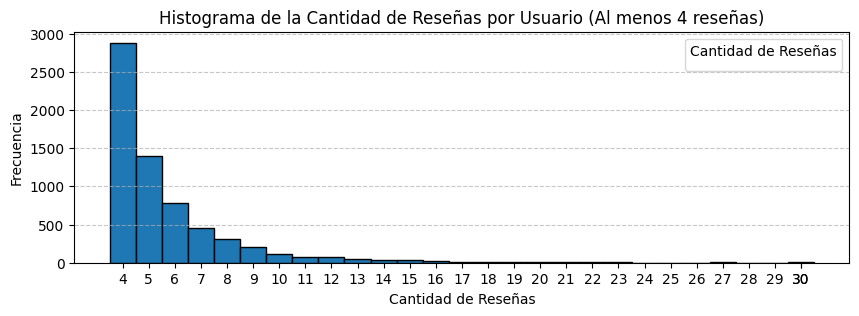

In [44]:
# Contar la cantidad de reseñas por user_id
reviews_count = df_reviewsGoogle['user_id'].value_counts()

# Filtrar los usuarios con más de 7 reseñas
filtered_reviews_count = reviews_count[reviews_count > 3]

# Limitar la cantidad de reseñas a un máximo de 30 para agrupar en el histograma
filtered_reviews_count_clipped = filtered_reviews_count.clip(upper=30)

# Crear el histograma
plt.figure(figsize=(10, 3))
plt.hist(filtered_reviews_count_clipped, bins=list(range(4, 31)) + [31], edgecolor='black', align='left')
plt.title('Histograma de la Cantidad de Reseñas por Usuario (Al menos 4 reseñas)')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Frecuencia')
plt.xticks(list(range(4, 31)) + [30])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir una leyenda personalizada
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = list(range(4, 30)) + ['30+']
plt.legend(handles, custom_labels, title="Cantidad de Reseñas")

# Mostrar el histograma
plt.show()

In [45]:
# Merge para añadir avg_rating al df_reviewsGoogle
df_reviewsGoogle = df_reviewsGoogle.merge(df_metadatos[['gmap_id', 'avg_rating', 'general_category']], on='gmap_id', how='left')

# Renombrar la columna avg_rating a business_avg_rating
df_reviewsGoogle.rename(columns={'avg_rating': 'business_avg_rating'}, inplace=True)

# Crear la columna dif_rating
df_reviewsGoogle['dif_rating'] = df_reviewsGoogle['business_avg_rating'] - df_reviewsGoogle['rating']

# Calcular la cantidad de reseñas por usuario
user_reviews_count = df_reviewsGoogle['user_id'].value_counts().reset_index()
user_reviews_count.columns = ['user_id', 'reviews_count']

# Calcular la media de dif_rating por usuario
user_avg_dif_rating = df_reviewsGoogle.groupby('user_id')['dif_rating'].mean().reset_index()
user_avg_dif_rating.columns = ['user_id', 'avg_dif_rating']

# Calcular las reseñas por user_id y general_category
user_category_reviews = df_reviewsGoogle.groupby(['user_id', 'general_category']).size().reset_index(name='category_reviews')

# Pivote de los datos para tener general_category como columnas
user_category_pivot = user_category_reviews.pivot(index='user_id', columns='general_category', values='category_reviews').fillna(0).reset_index()

# Merge para combinar la cantidad de reseñas y la media de dif_rating por usuario
df_user_stats = user_reviews_count.merge(user_avg_dif_rating, on='user_id', how='left')

# Filtrar df_user_stats para incluir solo user_id con 8 reseñas o más
df_user_stats_filtered = df_user_stats[df_user_stats['reviews_count'] >= 4]

# Merge con df_user_stats_filtered para agregar las categorías
df_user_stats_filtered = df_user_stats_filtered.merge(user_category_pivot, on='user_id', how='left')



In [46]:
# Calcular la media de dif_rating en valor absoluto por usuario
user_avg_dif_modulo = df_reviewsGoogle.groupby('user_id')['dif_rating'].apply(lambda x: x.abs().mean()).reset_index()
user_avg_dif_modulo.columns = ['user_id', 'avg_dif_modulo']

# Merge para combinar avg_dif_modulo con df_user_stats_filtered
df_user_stats_filtered = df_user_stats_filtered.merge(user_avg_dif_modulo, on='user_id', how='left')

In [47]:
# Definir la lista de categorías
categories = ['Auto', 'Beauty', 'Buildings', 'Clothes', 'Education', 'Entertainment', 'Food', 'Health',
              'Home', 'Other', 'Religion', 'Services', 'Sports', 'Stores', 'Technology']

# Crear la columna sum_category
df_user_stats_filtered['sum_category'] = df_user_stats_filtered[categories].apply(lambda x: (x > 0).sum(), axis=1)

# Eliminar las columnas de categorías específicas
df_user_stats_filtered = df_user_stats_filtered.drop(columns=categories)

In [48]:
# Calcular máximo y mínimo de cada columna en df_user_stats_filtered
max_values = df_user_stats_filtered.max()
min_values = df_user_stats_filtered.min()

print("Valores máximos:")
print(max_values)
print("\nValores mínimos:")
print(min_values)

Valores máximos:
user_id           1.184396e+20
reviews_count     6.300000e+01
avg_dif_rating    3.380000e+00
avg_dif_modulo    3.380000e+00
sum_category      1.500000e+01
dtype: float64

Valores mínimos:
user_id           1.000094e+20
reviews_count     4.000000e+00
avg_dif_rating   -2.300000e+00
avg_dif_modulo    1.200000e-01
sum_category      1.000000e+00
dtype: float64


In [49]:
df_user_stats_filtered["reviews_count"].value_counts()

reviews_count
4     2880
5     1392
6      785
7      450
8      305
9      207
10     110
11      74
12      74
13      46
14      34
15      33
16      22
18      13
17      12
19      11
20       9
21       6
23       5
22       5
27       3
26       2
25       2
24       2
33       2
34       2
30       2
49       1
53       1
63       1
35       1
28       1
38       1
29       1
43       1
Name: count, dtype: int64

In [50]:
# Definir las condiciones y las puntuaciones correspondientes
conditions = [
    (df_user_stats_filtered['reviews_count'] > 9) & 
    (df_user_stats_filtered['avg_dif_rating'].between(-0.5, 0.5, inclusive='both')) & 
    (df_user_stats_filtered['avg_dif_modulo'] <= 1) &
    (df_user_stats_filtered['sum_category'] > 6),

    (df_user_stats_filtered['reviews_count'] > 9) & 
    #(df_user_stats_filtered['avg_dif_rating'].between(-0.5, 0.5, inclusive='both')) & 
    (df_user_stats_filtered['avg_dif_modulo'] <= 1) &
    (df_user_stats_filtered['sum_category'] > 6),

    #(df_user_stats_filtered['reviews_count'] > 9) &
    (df_user_stats_filtered['sum_category'] > 3) &
    (df_user_stats_filtered['avg_dif_modulo'] <= 1),

    (df_user_stats_filtered['avg_dif_modulo'] <= 1.5),
]

choices = [5, 4, 3, 2]

# Aplicar las condiciones y asignar la columna user_rating
df_user_stats_filtered['user_rating'] = np.select(conditions, choices, default=1)

In [51]:
df_user_stats_filtered["user_rating"].value_counts()

user_rating
2    3871
3    1998
1     476
5      81
4      70
Name: count, dtype: int64

#### 4. Creación de base de datos final de locales con usuarios ponderados

In [52]:
# Realizar el merge para añadir user_rating a df_reviewsGoogle_filtered
df_reviewsGoogle_filtered = df_reviewsGoogle_filtered.merge(df_user_stats_filtered[['user_id', 'user_rating']], on='user_id', how='left')

# Rellenar los valores faltantes en user_rating con 1
df_reviewsGoogle_filtered['user_rating'].fillna(1, inplace=True)

# Asegurar que user_rating sea de tipo entero si es necesario
df_reviewsGoogle_filtered['user_rating'] = df_reviewsGoogle_filtered['user_rating'].astype(int)

C:\Users\londe\AppData\Local\Temp\ipykernel_15364\3734679488.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_reviewsGoogle_filtered['user_rating'].fillna(1, inplace=True)


In [53]:
df_reviewsGoogle_filtered["user_rating"].value_counts()

user_rating
1    41886
2     6502
3     3391
5      333
4      295
Name: count, dtype: int64

In [54]:
# Paso 2: Calcular la suma ponderada de ratings y la suma ponderada de las ponderaciones por gmap_id
df_reviewsGoogle_filtered['weighted_rating'] = df_reviewsGoogle_filtered['rating'] * df_reviewsGoogle_filtered['user_rating']
df_reviewsGoogle_filtered['weight'] = df_reviewsGoogle_filtered['user_rating']

# Agrupar por gmap_id y calcular las sumas ponderadas
grouped = df_reviewsGoogle_filtered.groupby('gmap_id').agg(
    total_weighted_rating=('weighted_rating', 'sum'),
    total_weight=('weight', 'sum')
).reset_index()

# Paso 3: Calcular avg_rating_correction dividiendo la suma ponderada de ratings entre la suma ponderada de las ponderaciones
grouped['avg_rating_correction'] = grouped['total_weighted_rating'] / grouped['total_weight']

# Paso 4: Merge de avg_rating_correction con df_metadatos_filtered
df_metadatos_filtered = df_metadatos_filtered.merge(grouped[['gmap_id', 'avg_rating_correction']], on='gmap_id', how='left')


In [55]:
df_metadatos_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814 entries, 0 to 2813
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   address                2814 non-null   object 
 1   gmap_id                2814 non-null   object 
 2   latitude               2814 non-null   float64
 3   longitude              2814 non-null   float64
 4   category               2814 non-null   object 
 5   avg_rating             2814 non-null   float64
 6   num_of_reviews         2814 non-null   int64  
 7   Hours_day              2814 non-null   int64  
 8   Hours_night            2814 non-null   int64  
 9   general_category       2814 non-null   object 
 10  res_asian              2814 non-null   int64  
 11  res_latin              2814 non-null   int64  
 12  res_euro               2814 non-null   int64  
 13  res_fast               2814 non-null   int64  
 14  res_vegan              2814 non-null   int64  
 15  reli

In [56]:
# Contar los gmap_id únicos en cada DataFrame
gmap_ids_reviews = set(df_reviewsGoogle_filtered['gmap_id'])
gmap_ids_metadatos = set(df_metadatos_filtered['gmap_id'])

# Contar el número de gmap_id únicos en cada DataFrame
count_gmap_ids_reviews = len(gmap_ids_reviews)
count_gmap_ids_metadatos = len(gmap_ids_metadatos)

# Encontrar los gmap_id que están en ambos DataFrames
common_gmap_ids = gmap_ids_reviews.intersection(gmap_ids_metadatos)
count_common_gmap_ids = len(common_gmap_ids)

# Encontrar los gmap_id que faltan en cada DataFrame
gmap_ids_missing_in_reviews = gmap_ids_metadatos - gmap_ids_reviews
gmap_ids_missing_in_metadatos = gmap_ids_reviews - gmap_ids_metadatos

count_gmap_ids_missing_in_reviews = len(gmap_ids_missing_in_reviews)
count_gmap_ids_missing_in_metadatos = len(gmap_ids_missing_in_metadatos)

# Resultados
print(f"gmap_id únicos en df_reviewsGoogle_filtered: {count_gmap_ids_reviews}")
print(f"gmap_id únicos en df_metadatos_filtered: {count_gmap_ids_metadatos}")
print(f"gmap_id comunes en ambos DataFrames: {count_common_gmap_ids}")
print(f"gmap_id faltantes en df_reviewsGoogle_filtered: {count_gmap_ids_missing_in_reviews}")
print(f"gmap_id faltantes en df_metadatos_filtered: {count_gmap_ids_missing_in_metadatos}")

gmap_id únicos en df_reviewsGoogle_filtered: 767
gmap_id únicos en df_metadatos_filtered: 2814
gmap_id comunes en ambos DataFrames: 767
gmap_id faltantes en df_reviewsGoogle_filtered: 2047
gmap_id faltantes en df_metadatos_filtered: 0


In [57]:
df_metadatos_filtered[["avg_rating","avg_rating_correction"]].head()

,avg_rating,avg_rating_correction
0,4.4,4.565217
1,4.0,4.230769
2,4.4,NaN
3,4.3,4.777778
4,4.3,4.484848


CARGA EN REPOSITORIO LOCAL:

In [58]:
# Guardar df_metadatos_filtered como un archivo CSV
df_metadatos_filtered.to_csv('Archivos/locales_LA.csv', index=False)

# Guardar df_metadatos_filtered como un archivo CSV
df_reviewsGoogle_filtered.to_csv('Archivos/reviews_LA.csv', index=False)

## Carga (LOAD)

Generamos fechas en los archivos para poder usar como variable temporal y controlar la subida:

In [59]:
%run genera_fechas.py

## 1 - CARGA EN MYSQL:

La carga es incremental, en caso de no existir las tablas las crea, si los datos a cargar son los mismos que los que estan no se cargan, y si hy datos nuevos sólo carga los nuevos.

1 - Script para carga incremental MySQL:

In [68]:
%run carga_incremental_sql.py

La tabla metadatos_ml ya existe.
Columna 'category' en la tabla metadatos_ml modificada a TEXT
Fecha más reciente en MySQL (metadatos_ml): 2024-07-18
Fecha más reciente en los archivos: 2024-07-18
No hay filas nuevas para cargar
La tabla reviewsGoogle_ml ya existe.
La columna 'category' no existe en la tabla reviewsGoogle_ml
Fecha más reciente en MySQL (reviewsGoogle_ml): 2024-07-18
Fecha más reciente en los archivos: 2024-07-18
No hay filas nuevas para cargar
La tabla locales_la ya existe.
Columna 'category' en la tabla locales_la modificada a TEXT
Fecha más reciente en MySQL (locales_la): 2024-07-18
Fecha más reciente en los archivos: 2024-07-18
No hay filas nuevas para cargar
La tabla reviews_la ya existe.
La columna 'category' no existe en la tabla reviews_la
Fecha más reciente en MySQL (reviews_la): 2024-07-18
Fecha más reciente en los archivos: 2024-07-18
No hay filas nuevas para cargar
Conexión a MySQL cerrada


## 2 - CARGA EN GCP BIGQUERY:


1 - Script para carga incremental MySQL:

In [67]:
%run carga_incremental_gcp.py

Tabla: findeden.findeden.metadatos_ML
Fecha más reciente en la nube: 2024-07-16 00:00:00
Fecha más reciente en el repositorio local: 2024-07-18 00:00:00
Se subieron 100 filas nuevas.
Tabla: findeden.findeden.reviewsGoogle_ML
Fecha más reciente en la nube: 2024-07-16 00:00:00
Fecha más reciente en el repositorio local: 2024-07-18 00:00:00
Se subieron 100 filas nuevas.
Tabla: findeden.findeden.locales_LA
Fecha más reciente en la nube: 2024-07-16 00:00:00
Fecha más reciente en el repositorio local: 2024-07-18 00:00:00
Se subieron 100 filas nuevas.
Tabla: findeden.findeden.reviews_LA
Fecha más reciente en la nube: 2024-07-16 00:00:00
Fecha más reciente en el repositorio local: 2024-07-18 00:00:00
Se subieron 100 filas nuevas.
Tabla: findeden.findeden.Contratos
Fecha más reciente en la nube: 2024-07-16 00:00:00
Fecha más reciente en el repositorio local: 2024-07-18 00:00:00
Se subieron 100 filas nuevas.
Tabla: findeden.findeden.Inquilinos
Fecha más reciente en la nube: 2024-07-16 00:00:00
F

## 3 - GENERACION DE DATOS DE PRUEBA:

1 - Script para generar 100 nuevas entradas en los archivos:

In [65]:
%run genera_entradas.py

## 2 - Crear ETL local como script de Python

In [ ]:
!jupyter nbconvert --to script ETL.ipynb

## 3 - Generar el archivo requirements.txt


In [ ]:
!pip freeze > requirements.txt